In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


sessionRegressionDF = pd.read_csv('data/sessionRegressionDF.csv', delimiter = ',')

# ##############################################
# Keep only values from the "Bad" calls, where 1 < MOS < 3.5
sessionRegressionDF = sessionRegressionDF[(sessionRegressionDF.meanOpinionScore < 3.5) & (sessionRegressionDF.meanOpinionScore > 1)]

# ##############################################
# Remove all rows that MOS is NaN
sessionRegressionDF = sessionRegressionDF.dropna(subset=['meanOpinionScore'])


# ##############################################
# Remove all columns that the number of blank values is > 40%
countOfNaN = sessionRegressionDF.isna().sum()
columnstoDrop = []
for colDependencies in sessionRegressionDF.columns:
    total_rows = sessionRegressionDF[colDependencies].count() + 1
    if countOfNaN[colDependencies] > (0.6 * total_rows):
        columnstoDrop.append(colDependencies)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)

# ##############################################
# Update the independent variables that will be used and then drop all rows that the feature's value is NaN 
independentVariables = list(sessionRegressionDF.columns)
sessionRegressionDF = sessionRegressionDF.dropna(subset = independentVariables)


### ##################################################
# Create an enumeration for each column that the datatype is string
mappingColumns = {}
# Replace the String values with a Enumeration
for colDependencies in sessionRegressionDF.columns:
    columnDataType = sessionRegressionDF.dtypes[colDependencies]
    if(columnDataType == 'object'):
        sessionRegressionDF[colDependencies] = sessionRegressionDF[colDependencies].astype("category").cat.codes
        
        #mapping = {k: v for v, k in enumerate(sessionRegressionDF[colDependencies].unique())}
        #mappingColumns[colDependencies] = mapping
        #sessionRegressionDF[colDependencies] = sessionRegressionDF[colDependencies].map(mapping)


### ##################################################
# Remove columns that its variance is 0.0. These features are not going to affect the target (Y = meanOpinionScore)
columnstoDrop = []
for colDependencies in sessionRegressionDF.columns:
    variance = sessionRegressionDF.var()[colDependencies]
    if variance == 0.0:
        columnstoDrop.append(colDependencies)

sessionRegressionDF = sessionRegressionDF.drop(columns=columnstoDrop)


sessionRegressionDF = sessionRegressionDF[(np.abs(stats.zscore(sessionRegressionDF)) < 2.5).all(axis=1)]


# ##################################################
# Set the Target (Y) to 'meanOpinionScore' and then delete the meanOpinionScore from the list of independent variables
target = pd.DataFrame(sessionRegressionDF['meanOpinionScore'], columns=['meanOpinionScore'])
sessionRegressionDF = sessionRegressionDF.drop(columns=['meanOpinionScore'])

# ##################################################
# Update the list of independent variables based on the latest calculations
independentVariables = list(sessionRegressionDF.columns)

X = sessionRegressionDF[independentVariables]
y = target['meanOpinionScore']

# Note the difference in argument order
model = sm.OLS(y, X)
regressionResult = model.fit()


# Print out the statistics
print(regressionResult.summary())


print("\n=======================================================================================")
print("List of parameters ordered by abs(coef) and p-value < 0.005")
lowPvalues = regressionResult.pvalues[regressionResult.pvalues < 0.005]
lowPvaluesNames = lowPvalues.index.tolist()
listOfSignificantFactors = regressionResult.params.filter(items=lowPvaluesNames).abs().sort_values(ascending=False).index.tolist()

print(regressionResult.params.filter(items=listOfSignificantFactors))

                                 OLS Regression Results                                
Dep. Variable:       meanOpinionScore   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              4396.
Date:                Wed, 11 Aug 2021   Prob (F-statistic):                        0.00
Time:                        13:37:18   Log-Likelihood:                         -93.869
No. Observations:                 469   AIC:                                      209.7
Df Residuals:                     458   BIC:                                      255.4
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

<AxesSubplot:>

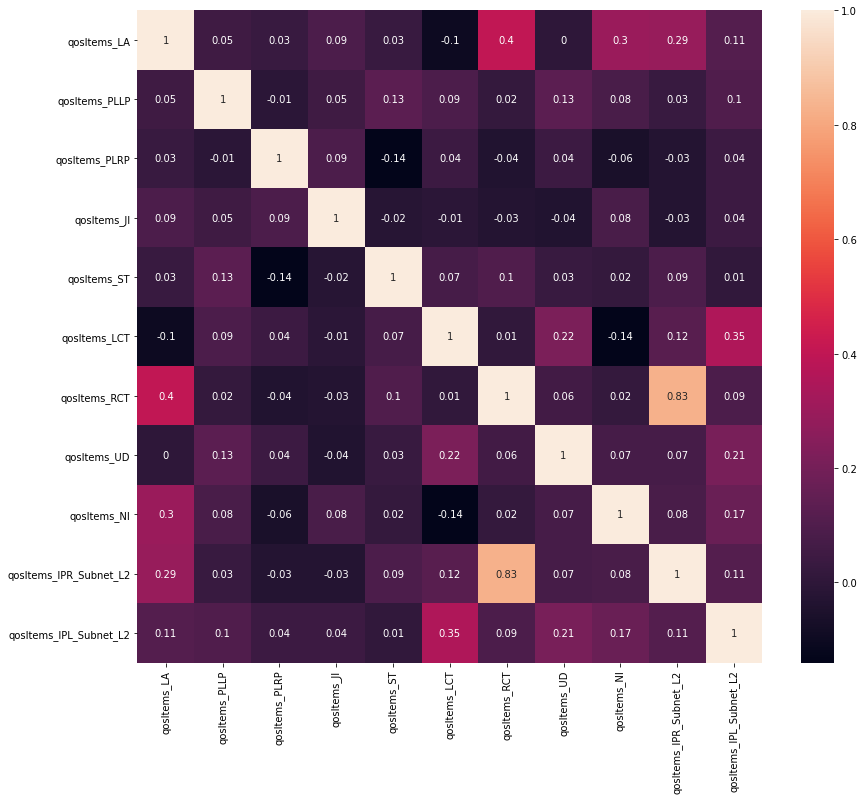

In [3]:
correlation_matrix = sessionRegressionDF.corr().round(2)
plt.figure(figsize=(14, 12))  
sns.heatmap(data=correlation_matrix, annot=True)

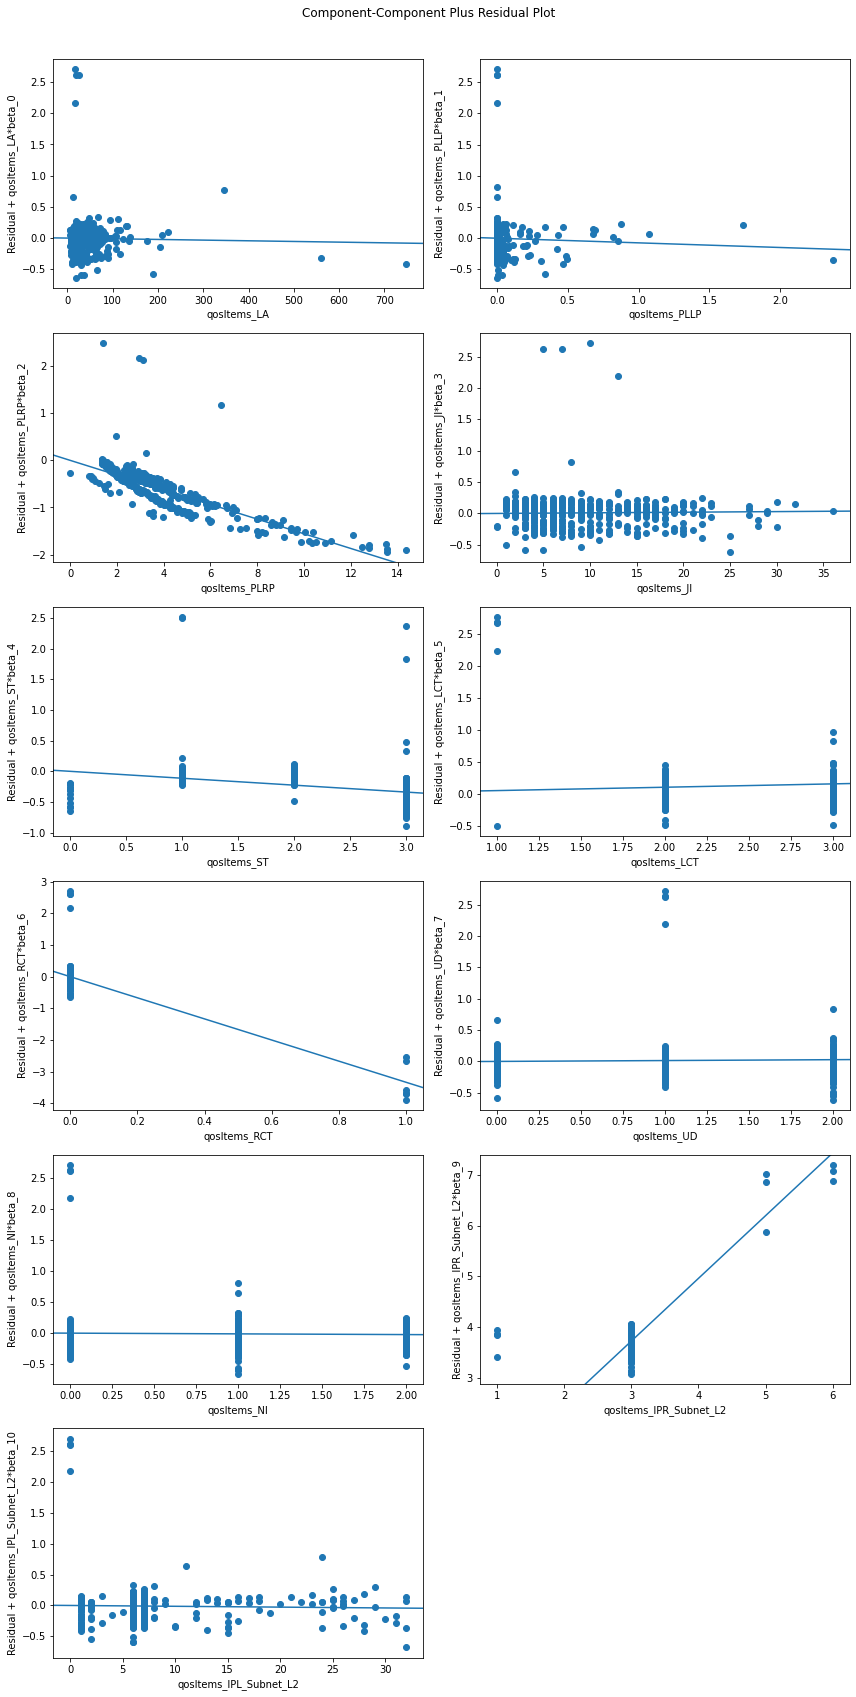

In [44]:
fig = plt.figure(figsize=(12, 24))
fig = sm.graphics.plot_ccpr_grid(regressionResult, fig=fig)